# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import asc, desc, col, udf, lit
from pyspark.sql.functions import sum as Fsum, max as Fmax, count as Fcount, avg as Favg, min as Fmin
import pandas as pd

from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier, LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
mini_sparkify_event_data = spark.read.json("mini_sparkify_event_data.json")
mini_sparkify_event_data.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
# how many items in dataset?
mini_sparkify_event_data.count()

286500

In [5]:
# dataset schema?
mini_sparkify_event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
#clean records without userids or sessionids
data_valid = mini_sparkify_event_data.dropna(how='any', subset=["userId","sessionId"])

In [7]:
# count after clearning
data_valid.count()

286500

In [8]:
# show 20 rows of userId
data_valid.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



empty userId must be dropped also.

In [9]:
# clean empty string
data_valid = data_valid.filter(data_valid["userId"] != "")

In [10]:
# count of rows after cleaning
data_valid.count()

278154

In [11]:
data_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [12]:
# see history of user 10
data_valid.select(["userId", "page", "ts", "level", "song", "sessionId"]).where(data_valid.userId == "10").show()

+------+----------+-------------+-----+--------------------+---------+
|userId|      page|           ts|level|                song|sessionId|
+------+----------+-------------+-----+--------------------+---------+
|    10|  NextSong|1538965220000| paid|       Ses Monuments|        9|
|    10|  NextSong|1538965485000| paid|         Morning Sky|        9|
|    10|  NextSong|1538965685000| paid|Du Hast'n Freund ...|        9|
|    10|  NextSong|1538965893000| paid|             Playera|        9|
|    10|  NextSong|1538966419000| paid|     Burnin' For You|        9|
|    10|  NextSong|1538966691000| paid|      Sky Is Falling|        9|
|    10|  NextSong|1538966898000| paid|      Skinhead Stomp|        9|
|    10| Thumbs Up|1538966899000| paid|                null|        9|
|    10|  NextSong|1538967004000| paid|      You're The One|        9|
|    10|  NextSong|1538967243000| paid|        Strange Days|        9|
|    10|  NextSong|1538967507000| paid|    Addicted To Love|        9|
|    1

In [13]:
# calculating statistics by hour
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour, IntegerType())

In [14]:
data_valid = data_valid.withColumn("hour", get_hour(data_valid.ts))

In [15]:
# convert ts to time format
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

In [16]:
data_valid = data_valid.withColumn("time", get_time(data_valid.ts))

In [17]:
data_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour=0, time='2018-10-01 00:01:57')

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [18]:
# who ever hit Cancellation Confirmation?
data_valid.select(["userId", "page", "time", "level", "sessionId"]).where(data_valid.page == "Cancellation Confirmation").sort('userId').show()

+------+--------------------+-------------------+-----+---------+
|userId|                page|               time|level|sessionId|
+------+--------------------+-------------------+-----+---------+
|100001|Cancellation Conf...|2018-10-02 16:36:45| free|       53|
|100003|Cancellation Conf...|2018-10-11 16:19:41| free|       86|
|100005|Cancellation Conf...|2018-10-19 17:57:05| free|      115|
|100006|Cancellation Conf...|2018-10-05 15:24:30| free|        6|
|100007|Cancellation Conf...|2018-11-29 11:45:09| paid|      205|
|100009|Cancellation Conf...|2018-10-27 03:31:44| free|      145|
|100011|Cancellation Conf...|2018-10-01 18:04:45| free|       40|
|100012|Cancellation Conf...|2018-11-01 19:35:00| free|      156|
|100013|Cancellation Conf...|2018-11-02 18:53:36| paid|      165|
|100014|Cancellation Conf...|2018-11-20 19:04:09| paid|      185|
|100015|Cancellation Conf...|2018-11-24 15:35:53| paid|      188|
|100017|Cancellation Conf...|2018-10-20 19:14:07| free|       17|
|100019|Ca

In [19]:
# create churn label
flag_churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
data_valid = data_valid.withColumn('churn_event', flag_churn_event('page'))

# label user who churned
windowval = Window.partitionBy('userId')
df = data_valid.withColumn('churn', Fmax('churn_event').over(windowval))

In [20]:
df.select(["userId", "page", "time", "level", "sessionId", "churn"]).where(df.userId == 101).sort("time").show()

+------+-----------+-------------------+-----+---------+-----+
|userId|       page|               time|level|sessionId|churn|
+------+-----------+-------------------+-----+---------+-----+
|   101|       Home|2018-10-01 01:50:05| free|      100|    1|
|   101|   NextSong|2018-10-01 01:53:38| free|      100|    1|
|   101|   NextSong|2018-10-01 01:56:56| free|      100|    1|
|   101|   NextSong|2018-10-01 02:01:29| free|      100|    1|
|   101|   NextSong|2018-10-01 02:03:55| free|      100|    1|
|   101|   NextSong|2018-10-01 02:07:32| free|      100|    1|
|   101|       Help|2018-10-01 02:12:03| free|      100|    1|
|   101|   NextSong|2018-10-01 02:13:18| free|      100|    1|
|   101|   NextSong|2018-10-01 02:16:51| free|      100|    1|
|   101|   NextSong|2018-10-01 02:20:32| free|      100|    1|
|   101|   NextSong|2018-10-01 02:24:56| free|      100|    1|
|   101|   NextSong|2018-10-01 02:29:33| free|      100|    1|
|   101|   NextSong|2018-10-01 02:33:13| free|      100

In [21]:
df.select(["userId", "page", "time", "level", "sessionId", "churn"]).where(df.userId == 10).sort("time").show()

+------+----------+-------------------+-----+---------+-----+
|userId|      page|               time|level|sessionId|churn|
+------+----------+-------------------+-----+---------+-----+
|    10|  NextSong|2018-10-08 02:20:20| paid|        9|    0|
|    10|  NextSong|2018-10-08 02:24:45| paid|        9|    0|
|    10|  NextSong|2018-10-08 02:28:05| paid|        9|    0|
|    10|  NextSong|2018-10-08 02:31:33| paid|        9|    0|
|    10|  NextSong|2018-10-08 02:40:19| paid|        9|    0|
|    10|  NextSong|2018-10-08 02:44:51| paid|        9|    0|
|    10|  NextSong|2018-10-08 02:48:18| paid|        9|    0|
|    10| Thumbs Up|2018-10-08 02:48:19| paid|        9|    0|
|    10|  NextSong|2018-10-08 02:50:04| paid|        9|    0|
|    10|  NextSong|2018-10-08 02:54:03| paid|        9|    0|
|    10|  NextSong|2018-10-08 02:58:27| paid|        9|    0|
|    10|Add Friend|2018-10-08 02:58:28| paid|        9|    0|
|    10|Add Friend|2018-10-08 02:58:29| paid|        9|    0|
|    10|

In [23]:
df.where(df.churn==1).count()

44864

In [24]:
df.where(df.churn==0).count()

233290

---

In [22]:
def show_plot_spark_df(df, col):
    """
    plot distribution plot of a spark dataframe differing status of 'churn'
    
    input:
    df: dataframe. input dataframe.
    col: string. label of target of analysis
    """
    # convert to pandas df
    df_pd = df.toPandas()
    df_pd = df_pd.set_index(col)
    df_pd = df_pd[df_pd["churn"]==1].join(df_pd[df_pd["churn"]==0], lsuffix='_churn_true', rsuffix='_churn_false').drop(columns = ["churn_churn_true", "churn_churn_false"])
    ax1 = df_pd.plot.bar()
    ax1.set_ylabel("Abs Count")
    
    df_percentage = df_pd
    df_percentage['percentage_churn_true'] = df_percentage['count_churn_true'] / sum(df_percentage['count_churn_true']) * 100
    df_percentage['percentage_churn_false'] = df_percentage['count_churn_false'] / sum(df_percentage['count_churn_false']) * 100
    df_percentage.drop(columns = ["count_churn_true", "count_churn_false"], inplace=True)
    ax2 = df_percentage.plot.bar()
    ax2.set_ylabel("Percentage")

**churned vs stayed Analysis 1:**
actions distribution (except Cancel, Cancellation Confirmation and played song)

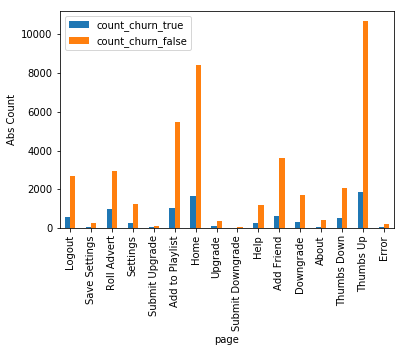

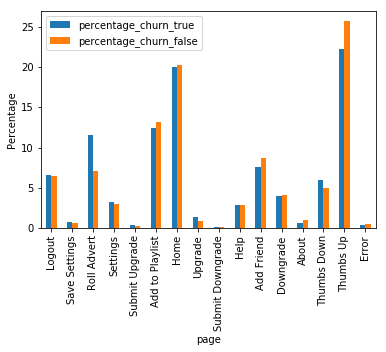

In [23]:
df_a1 = df.filter((df.page != "Cancel") & (df.page != "Cancellation Confirmation") & (df.page != "NextSong")).groupby(['churn', 'page']).count()
show_plot_spark_df(df_a1, 'page')

**churned vs stayed Analysis 2:**
gender distribution

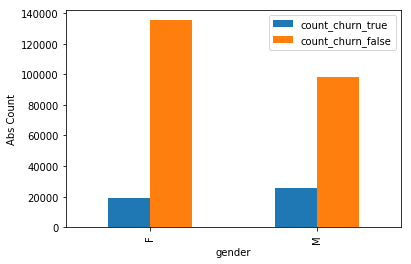

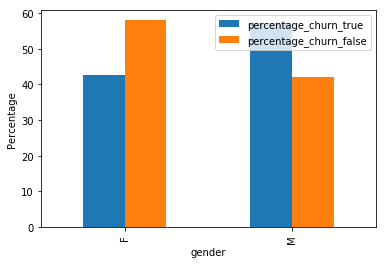

In [24]:
df_a3 = df.groupby(['churn', 'gender']).count()
show_plot_spark_df(df_a3, 'gender')

**churned vs stayed Analysis 3:**
Time(hour) distribution

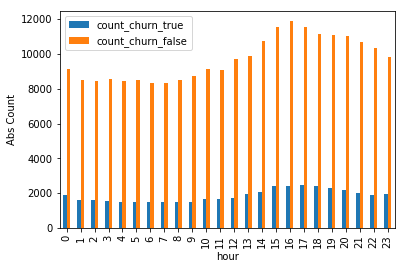

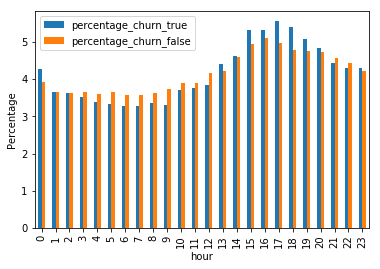

In [25]:
df_a4 = df.groupby(['churn', 'hour']).count().sort("hour")
show_plot_spark_df(df_a4, 'hour')

**Conclusion**

First of all, more users choose to stay instead of churn, therefore the count of stayed user is much bigger than the count of churned user. In oder to compare, we convert the absolute value to percentage value.

In analysis 1, we noticed that the stayed user visitied Thumbs up page more than the churned user. Meanwhile, the percentage roll advert. visit of churned group is much higher than the stayed group.

In analysis 2, we noticed that in churned group, the number of male is more than female. Females seem to like sparkify more.

In analysis 3, we noticed that the churned uses tent to use more between 15 - 20 than stayed user. It is the time when server is relatively busy, maybe this gave them bad experience.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [26]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- time: string (nullable = true)
 |-- churn_event: integer (nullable = true)
 |-- churn: integer (nullable = true)



In [27]:
df.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', hour=12, time='2018-10-08 12:58:54', churn_event=0, churn=0)

**Label df: churn**

In [28]:
# Churn label
label = df \
    .select('userId', col('churn').alias('label')) \
    .dropDuplicates()
label.sort("userId").show()

+------+-----+
|userId|label|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
|100004|    0|
|100005|    1|
|100006|    1|
|100007|    1|
|100008|    0|
|100009|    1|
|100010|    0|
|100011|    1|
|100012|    1|
|100013|    1|
|100014|    1|
|100015|    1|
|100016|    0|
|100017|    1|
|100018|    0|
+------+-----+
only showing top 20 rows



**Feature df(s) 0: count of each action of pages** (except Cancel and Cancel Confirmation)

In [29]:
pages = df.select("page").where((df.page != "Cancel") & (df.page != "Cancellation Confirmation")).dropDuplicates()

In [30]:
actions = [r["page"] for r in pages.collect()]

In [31]:
f0 = [
    df\
    .select('userID','page') \
    .where(df.page == a) \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'count_' + a.replace(" ", "")) 
    for a in actions]

In [32]:
f0[0].sort("userId").show()

+------+---------------------+
|userID|count_SubmitDowngrade|
+------+---------------------+
|   100|                    1|
|100004|                    2|
|100008|                    1|
|100009|                    1|
|100012|                    1|
|100015|                    1|
|100016|                    1|
|100018|                    2|
|100025|                    1|
|   103|                    1|
|   109|                    1|
|    11|                    1|
|    12|                    1|
|    13|                    2|
|   131|                    2|
|   140|                    3|
|   141|                    1|
|    20|                    2|
|200003|                    2|
|200009|                    1|
+------+---------------------+
only showing top 20 rows



**Feature df 1: gender**

In [33]:
f1 = df \
    .select("userId", "gender") \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int'))
f1.sort("userId").show()

+------+------+
|userId|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
|100004|     1|
|100005|     0|
|100006|     1|
|100007|     1|
|100008|     1|
|100009|     0|
|100010|     1|
|100011|     0|
|100012|     0|
|100013|     1|
|100014|     0|
|100015|     1|
|100016|     0|
|100017|     0|
|100018|     0|
+------+------+
only showing top 20 rows



**Feature df 2: life time**

In [34]:
f2 = df \
    .select('userId','registration','ts') \
    .withColumn('lifetime',(df.ts-df.registration)) \
    .groupBy('userId') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', (col('lifetime')/1000/3600/24).alias('lifetime'))
f2.sort("userId").show()

+------+------------------+
|userId|          lifetime|
+------+------------------+
|    10| 51.76265046296297|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
|100004|172.44008101851853|
|100005| 85.19559027777778|
|100006| 9.127164351851851|
|100007|115.38761574074074|
|100008| 68.22856481481482|
|100009| 37.43827546296296|
|100010|  55.6436574074074|
|100011| 5.165115740740741|
|100012| 43.05261574074074|
|100013| 44.17873842592593|
|100014| 85.08340277777778|
|100015| 67.87921296296297|
|100016| 75.01533564814815|
|100017| 78.88440972222223|
|100018|110.71211805555555|
+------+------------------+
only showing top 20 rows



**Feature df 3: avg, min, max time per session**

In [35]:
f3= df \
    .select("userId", "sessionId", "length") \
    .dropDuplicates() \
    .groupby("userId", "sessionId")\
    .agg(Fsum("length"))\
    .groupby("userId")\
    .agg(Favg("sum(length)").alias("avg_session_length"), Fmin("sum(length)").alias("min_session_length"), Fmax("sum(length)").alias("max_session_length"))
f3.sort("userId").show()

+------+------------------+------------------+------------------+
|userId|avg_session_length|min_session_length|max_session_length|
+------+------------------+------------------+------------------+
|    10|26700.002281666675|        5685.43701| 87251.22061000002|
|   100|19285.529964117646|411.40108999999995| 58440.64074999997|
|100001|      8768.4355375|        3909.74151|13057.543319999997|
|100002|     12166.3130375|         465.60608|       43355.37714|
|100003|6153.2096599999995|         387.44725|       11918.97207|
|100004|11383.596271500002|         141.84444|       52856.90311|
|100005| 9259.280502499998|4880.1612000000005|12788.221759999999|
|100006| 5854.891049999998| 5854.891049999998| 5854.891049999998|
|100007|11417.184301111112| 810.4471599999999| 39754.45530000001|
|100008| 30652.07786499999|3559.2547700000005|114861.40077999994|
|100009|12811.219937999998|         504.05787|39515.720870000005|
|100010|  9524.74959857143|        1597.56743|19634.667400000002|
|100011|  

**Feature df 4: average number of songs heard per session**

In [36]:
f4 = df.where('page == "NextSong"') \
    .groupby(['userId', 'sessionId']) \
    .count() \
    .groupby(['userId']) \
    .agg({'count':'avg'}) \
    .withColumnRenamed('avg(count)', 'avg_songs_played')
f4.sort("userId").show()

+------+------------------+
|userId|  avg_songs_played|
+------+------------------+
|    10|112.16666666666667|
|   100| 78.88235294117646|
|100001|             33.25|
|100002|             48.75|
|100003|              25.5|
|100004|              47.1|
|100005|              38.5|
|100006|              26.0|
|100007|              47.0|
|100008|128.66666666666666|
|100009|              51.8|
|100010|39.285714285714285|
|100011|              11.0|
|100012| 79.33333333333333|
|100013|              87.0|
|100014|42.833333333333336|
|100015| 66.66666666666667|
|100016|             66.25|
|100017|              52.0|
|100018|              50.1|
+------+------------------+
only showing top 20 rows



**Feature df 5: failed actions between 15:00 -20:00**

In [37]:
f5 = df \
    .select('userId','hour','status') \
    .where((df.status != 200) & (15 <= df.hour) & (df.hour <=20)) \
    .groupby("userId")\
    .agg(Fcount("status").alias("count_failed_actions"))
f5.sort("userId").show()

+------+--------------------+
|userId|count_failed_actions|
+------+--------------------+
|    10|                  17|
|   100|                 104|
|100001|                   2|
|100002|                   5|
|100003|                   3|
|100004|                  26|
|100005|                  13|
|100006|                   5|
|100007|                   4|
|100008|                  35|
|100009|                  16|
|100010|                  11|
|100011|                   2|
|100012|                  28|
|100013|                  41|
|100014|                  25|
|100015|                  16|
|100016|                  23|
|100017|                   4|
|100018|                  30|
+------+--------------------+
only showing top 20 rows



**join all feature dataframes together**

In [38]:
f_list = f0 + [f1, f2, f3, f4, f5, label]

In [39]:
merged_df = reduce(lambda a,b: a.join(b,'userID','outer').fillna(0),f_list) 

In [40]:
merged_df.printSchema()

root
 |-- userID: string (nullable = true)
 |-- count_SubmitDowngrade: long (nullable = true)
 |-- count_ThumbsDown: long (nullable = true)
 |-- count_Home: long (nullable = true)
 |-- count_Downgrade: long (nullable = true)
 |-- count_RollAdvert: long (nullable = true)
 |-- count_Logout: long (nullable = true)
 |-- count_SaveSettings: long (nullable = true)
 |-- count_About: long (nullable = true)
 |-- count_Settings: long (nullable = true)
 |-- count_AddtoPlaylist: long (nullable = true)
 |-- count_AddFriend: long (nullable = true)
 |-- count_NextSong: long (nullable = true)
 |-- count_ThumbsUp: long (nullable = true)
 |-- count_Help: long (nullable = true)
 |-- count_Upgrade: long (nullable = true)
 |-- count_Error: long (nullable = true)
 |-- count_SubmitUpgrade: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- lifetime: double (nullable = false)
 |-- avg_session_length: double (nullable = false)
 |-- min_session_length: double (nullable = false)
 |-- max_session_

In [41]:
df_feature = merged_df.drop("UserId")

In [42]:
df_feature.columns

['count_SubmitDowngrade',
 'count_ThumbsDown',
 'count_Home',
 'count_Downgrade',
 'count_RollAdvert',
 'count_Logout',
 'count_SaveSettings',
 'count_About',
 'count_Settings',
 'count_AddtoPlaylist',
 'count_AddFriend',
 'count_NextSong',
 'count_ThumbsUp',
 'count_Help',
 'count_Upgrade',
 'count_Error',
 'count_SubmitUpgrade',
 'gender',
 'lifetime',
 'avg_session_length',
 'min_session_length',
 'max_session_length',
 'avg_songs_played',
 'count_failed_actions',
 'label']

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

**vectorize the features**

In [43]:
cols = df_feature.columns
cols.remove("label")

In [44]:
assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
df_feature = assembler.transform(df_feature)

**scale the features**

In [45]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(df_feature)
df_feature = scalerModel.transform(df_feature)

**split the data into train, validation, and test sets**

In [46]:
train, rest = df_feature.randomSplit([0.6, 0.4], seed=42)
validation, test = rest.randomSplit([0.5, 0.5], seed=42)

**start training models**

In [47]:
def train_model(classifier, train, validation, test, param_grid=None, evaluation=True):
    """
    train model using dataframes
    
    input: 
    classifier: classifier object, initialized classifier
    train: dataframe, training set
    validation: dataframe, validation set
    test: dataframe, test set
    param_grid: ParamGridBuilder object, optional, used for gridsearch
    evalutation: Bool, if print out evaluation results
    
    output:
    cv_model: classifier object, trained model with trainning set
    results_validation: dataframe, result dataframe applying the model to validation set
    results_test: dataframe, result dataframe applying the model to test set
    """
    if param_grid is None:
        param_grid = ParamGridBuilder().build()
    f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    crossvalidator = CrossValidator(
        estimator=classifier,
        estimatorParamMaps=param_grid,
        evaluator=f1_evaluator
    )
    cv_model = crossvalidator.fit(train)
    
    # result on test and validation set
    if evaluation:
        results_validation = cv_model.transform(validation)
        results_test = cv_model.transform(test)
        evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
        print('Validation:')
        print('Accuracy: {}'.format(evaluator.evaluate(results_validation, {evaluator.metricName: "accuracy"})))
        print('F-1 Score:{}'.format(evaluator.evaluate(results_validation, {evaluator.metricName: "f1"})))
        print('\n')
        print('Test:')
        print('Accuracy: {}'.format(evaluator.evaluate(results_test, {evaluator.metricName: "accuracy"})))
        print('F-1 Score:{}'.format(evaluator.evaluate(results_test, {evaluator.metricName: "f1"})))

        return cv_model, results_validation, results_test
    else:
        return cv_model

**model 1: random forest**

In [49]:
rf = RandomForestClassifier()

In [51]:
%%time
cv_model_rf, results_validation, results_test = train_model(rf, train, validation, test)

Validation:
Accuracy: 0.8
F-1 Score:0.7701863354037268


Test:
Accuracy: 0.7647058823529411
F-1 Score:0.7215498639647246
CPU times: user 3.92 s, sys: 784 ms, total: 4.71 s
Wall time: 24min 24s


**model 2: linear svc**

In [49]:
lsvc = LinearSVC(maxIter=10)

In [50]:
%%time
cv_model_lsvc, results_validation, results_test = train_model(lsvc, train, validation, test)

Validation:
Accuracy: 0.6666666666666666
F-1 Score:0.5333333333333333


Test:
Accuracy: 0.7647058823529411
F-1 Score:0.6627450980392157
CPU times: user 5.23 s, sys: 1.58 s, total: 6.81 s
Wall time: 30min 10s


**model 3: GBT**

In [48]:
gbt = GBTClassifier(maxIter=10,seed=42)

In [49]:
%%time
cv_model_gbt, results_validation, results_test = train_model(gbt, train, validation, test)

Validation:
Accuracy: 0.6666666666666666
F-1 Score:0.6560846560846562


Test:
Accuracy: 0.7647058823529411
F-1 Score:0.7647058823529412
CPU times: user 10.7 s, sys: 2.66 s, total: 13.4 s
Wall time: 43min 36s


**conclusion**

The GBT Classifier performs the best out of three chosen classifiers, although the training time is the longest. In this usecase the traning time is not a critical point, therefore for us the optimal classifier will be GBTClassifier.

**Hyper-parameter tuning**

In [51]:
paramGrid_gbt = ParamGridBuilder().addGrid(gbt.maxDepth,[5, 10]).addGrid(gbt.stepSize,[0.2, 0.5]).build()

In [52]:
%%time
cv_model_gbt = train_model(gbt, train, validation, test, paramGrid_gbt, evaluation=False)
cv_model_gbt.avgMetrics

CPU times: user 40.6 s, sys: 9.75 s, total: 50.4 s
Wall time: 1h 51min 1s


In [53]:
cv_model_gbt.avgMetrics

[0.7291348305644842,
 0.7291348305644842,
 0.7248456968834226,
 0.7248456968834226]

In [64]:
gbt_best = GBTClassifier(maxIter=10,seed=42, maxDepth=5)
gbt_best_model = gbt_best.fit(train)
results_final = gbt_best_model.transform(test)

In [74]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test:')
print('Accuracy: {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "f1"})))

Test:
Accuracy: 0.7647058823529411
F-1 Score:0.7647058823529412


**conclusion**

default parameters give us the best performance

**feature importance analysis**

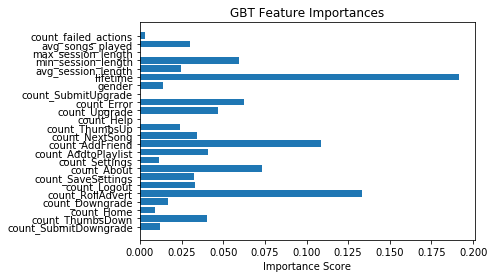

In [73]:
feat_imp = gbt_best_model.featureImportances
y_pos = np.arange(len(cols))
 
plt.barh(y_pos, feat_imp, align='center')
plt.yticks(y_pos, cols)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances');

**conclusion**

The top 1 relevant feature is the life time, which is actually already an indirect indicator of if the user like the app or platform or not. The users who like the app will definitely stay longer.
The second important feature is count of roll advert, which is as expected. As analyzed in churned vs stayed Analysis 1, if a user have to roll advertisement a lot, it might give them bad experience.
The third important feature is count of adding friends. It shows the power of a friendship. The more people a user can find who share the same music taste, the more possible the user will stay.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.